# Modules

In [1]:
import numpy as np

from mesa import Agent, Model
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
import matplotlib.pyplot as plt
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer

In [17]:
def get_sus(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0,0]
    return state

def get_exp(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0,1]
    return state

def get_inf(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0,2]
    return state

def get_rec(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0,3]
    return state

# CA class

In [12]:
class CellularAutomaton(Model):
    
    def __init__(
        self,
        height = 30,
        width = 30,
        mu = 0.0005,
        lam = 0.25,
        tau = 7,
        sig = 1/7,
        eps = 1/14,
        m = 1/8
    ):
        self.height = height
        self.width = width
        
        self.mu = mu
        self.lam = lam
        self.tau = tau
        self.sig = sig
        self.eps = eps
        self.m = m
        
        self.schedule = SimultaneousActivation(self)
        self.grid = Grid(self.width, self.height, torus=False)

        self.datacollector = DataCollector(
            model_reporters =  {
                "sus": get_sus,
                "exp": get_exp,
                "inf": get_inf,
                "rec": get_rec
                }
            )

        for (contents, i, j) in self.grid.coord_iter():
            FSM = FSM_SEIR((i,j), self)
            if np.random.random() < 0.005:
                FSM.state = np.zeros((7,4))
                FSM.state[:,0] = 0.8
                FSM.state[:,2] = 0.2
            else:
                FSM.state = np.zeros((7,4))
                FSM.state[:,0] = 1
            self.grid.place_agent(FSM, (i,j))
            self.schedule.add(FSM)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

    def run(self, n):
        for _ in range(n):
            self.step()

# FSM class

In [9]:
class FSM_SEIR(Agent):
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.x, self.y = pos

        self.state = np.zeros((7,4))
        self._nextState = None
        self.counter = 0

    def step(self):
        neighbors = self.model.grid.get_neighbors((self.x,self.y), True)
        
        S,E,I,R = self.state[0,:]
        Stau, Etau, Itau, Rtau = self.state[6,:]
        
        Snew = S - self.model.lam * S * I - sum([self.model.m * self.model.lam * x.state[0,2] * S for x in neighbors]) + self.model.mu * (1 - S)
        Enew = E + self.model.lam * S * I + sum([self.model.m * self.model.lam * x.state[0,2] * S for x in neighbors]) - np.exp(- self.model.mu * self.model.tau) * (self.model.lam * Stau * Itau + sum([self.model.lam * self.model.m * x.state[6,2] * Stau for x in neighbors])) - E * self.model.sig - self.model.mu * E
        Inew = I + np.exp(- self.model.mu * self.model.tau) * (self.model.lam * Stau * Itau + sum([self.model.lam * self.model.m * x.state[6,2] * Stau for x in neighbors])) + E * self.model.sig - I * self.model.eps - self.model.mu * I
        Rnew = R + I * self.model.eps - self.model.mu*R
        
        S = round(100*Snew)/100
        E = round(100*Enew)/100
        I = round(100*Inew)/100
        R = round(100*Rnew)/100
        
        self._nextState = np.zeros((7,4))
        self._nextState[1:,:] = self.state[:6,:]
        self._nextState[0,:] = [S, E, I, R]
        
    def advance(self):
        self.state = self._nextState

# Run model

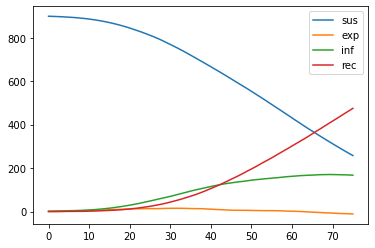

In [23]:
model = CellularAutomaton()

model.run(75)
    
df = model.datacollector.get_model_vars_dataframe()
df.plot()

# Plot density of infected

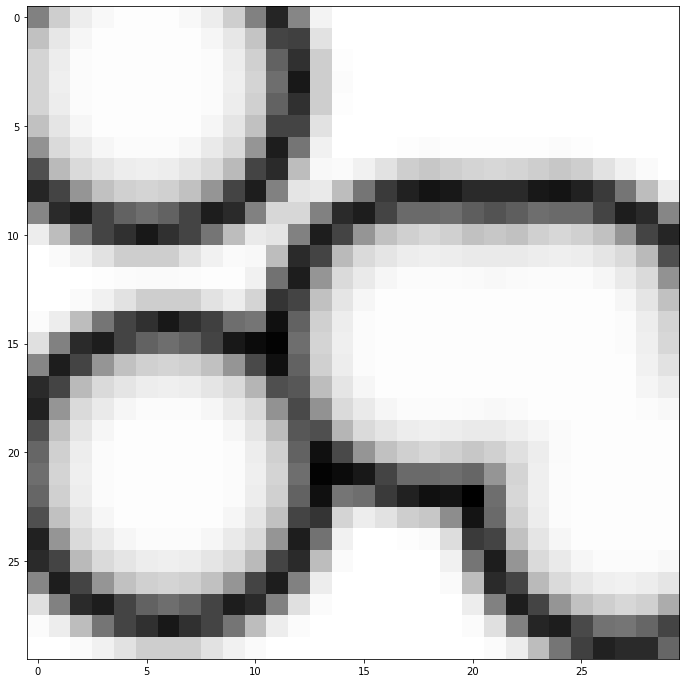

In [24]:
infected = np.zeros((30,30))
for (content, i, j) in model.grid.coord_iter():
    infected[i,j] = content.state[0,2]
    
plt.figure(figsize = (15,12))
plt.imshow(infected,cmap = 'Greys')